In [1]:
import netCDF4 as nc
from matplotlib import pyplot as plt
plt.ion()
import numpy as np
from netcdftime import utime
import os
import rasterio
import shutil

In [2]:
YEAR='2014'

In [3]:
fname = nc.Dataset('../data/icecharts-{}/merged-icecharts-{}.nc'.format(YEAR, YEAR))

In [4]:
fastice_dst = fname['ice_concentration'][:].astype(np.bool)

In [5]:
tsmp = fname['time']
cdftime = utime(tsmp.units)
timestamps = cdftime.num2date(tsmp[:])

In [6]:
def plot_nic(dst, outfile):
    plt.clf()
    plt.contour(dst, colors=['k'], levels=[-1], linestyles='solid')
    plt.contourf(dst, colors=['#e6f2ff', 'blue', 'green', 'yellow', 'orange', 'red', 'gray'], levels=np.unique(dst))
    plt.contourf(dst, colors=['white'], levels=[-1,-0.01])
    plt.text(200, 50, outfile,
        verticalalignment='bottom', horizontalalignment='right',
        color='black', fontsize=25)
    plt.savefig('nic'+outfile)

In [7]:
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.array(inarray)                  # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

In [8]:
#pers = np.zeros(fastice_dst.shape[1::])
#for i  in range(fastice_dst.shape[1]):
#    for j in range(fastice_dst.shape[2]):
#        o = rle(fastice_dst[:, i, j])
#        try:
##            pers[i,j] = o[0][o[2]][0]
#        except:
#            pass

In [9]:
count= np.zeros(fastice_dst.shape[1::])
mask = np.ones(count.shape, dtype=np.bool)
switch = np.ones(count.shape)
for i in range(fastice_dst.shape[0]):
    switch *= fastice_dst[i]
    count += switch
count = np.where(count<=1, 0, count)    

In [10]:
#write rle to file
import shutil
template_tif = '/media/DataLocal/Projects/FjordIcePersistency/templates/svalbard_template.tif'
ofile_tif = 'svalbard_fastice_persistency_{}.tif'.format(YEAR)
shutil.copy(template_tif, ofile_tif)

In [11]:
template = rasterio.open(template_tif, 'r')
meta = template.meta.copy()

with rasterio.open(ofile_tif, 'w', **meta) as dst:
        dst.write((count/5.*7.).astype(rasterio.uint8), 1)

/home/mikhail/.virtualenvs/fjordice/local/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [12]:
template.close()

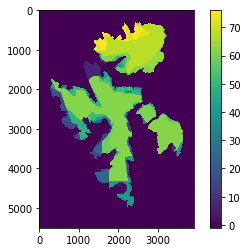

In [13]:
plt.imshow(count-1); plt.colorbar()